## Our comments

- We don't understand the difference in the Matlab and python form, it seems that only the center of mass is changing but we don't get why

# **MAFAT Radar Challenge - Plotting a Spectrogram**
In this notebook, the I/Q matrix is transformed and processed to visualize the signal.  
   
*What is it a Spectrogram?*    
A spectrogram is a visual representation of the spectrum of frequencies of a signal as it varies with time.   
A spectrogram is usually depicted as a heat map, the intensity shown by varying the color in the spectrogram.   

The data contains I/Q radar signals of humans or animals collected from different locations and times.   
Each signal of human or animal is a single track. The tracks in the dataset are split into 32 time-units segments.   
A track can have one or more segments.   
Each record in the dataset represents a single segment. 

[Competition website](https://competitions.codalab.org/competitions/25389)   
[MAFAT Challenge homepage](https://mafatchallenge.mod.gov.il/)

## Setup

In [1]:
import pickle
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.colors import LinearSegmentedColormap
from termcolor import colored

In [2]:
# Competition data is loaded from google drive
from google.colab import drive
mount_path = '/content/gdrive'
drive.mount(mount_path)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
# Set and test path to competition data files
competition_path = 'My Drive/Final Project ITC/MAFAT Challenge/Data'
try:
  if competition_path == 'INSERT HERE':
    print('Please enter path to competition data files:')
    competition_path = input()
  file_path = 'MAFAT RADAR Challenge - Training Set V1.csv'
  with open(f'{mount_path}/{competition_path}/{file_path}') as f:
    f.readlines()
  print(colored('Everything is setup correctly', color='green'))
except:
  print(colored('Please mount drive and set competition_path correctly',
                color='red'))

Everything is setup correctly


## Functions

### Data loading


In [4]:
def load_data(file_path):
  """
  Reads all data files (metadata and signal matrix data) as python dictionary,
  the pkl and csv files must have the same file name.

  Arguments:
    file_path -- {str} -- path to the iq_matrix file and metadata file

  Returns:
    Python dictionary
  """
  pkl = load_pkl_data(file_path)
  meta = load_csv_metadata(file_path)
  data_dictionary = {**meta, **pkl}
  
  for key in data_dictionary.keys():
    data_dictionary[key] = np.array(data_dictionary[key])

  return data_dictionary
  


def load_pkl_data(file_path):
  """
  Reads pickle file as a python dictionary (only Signal data).

  Arguments:
    file_path -- {str} -- path to pickle iq_matrix file

  Returns:
    Python dictionary
  """
  path = os.path.join(mount_path, competition_path, file_path + '.pkl')
  with open(path, 'rb') as data:
    output = pickle.load(data)
  return output


def load_csv_metadata(file_path):
  """
  Reads csv as pandas DataFrame (only Metadata).

  Arguments:
    file_path -- {str} -- path to csv metadata file

  Returns:
    Pandas DataFarme
  """
  path = os.path.join(mount_path, competition_path, file_path + '.csv')
  with open(path, 'rb') as data:
    output = pd.read_csv(data)
  return output

### Processing
The signals are represented in an I/Q matrix.    
I/Q is a representation of signals' frequency, amplitude, and phase as a complex number (you can read more [here]((http://www.ni.com/tutorial/4805/en/))).   
To plot the matrix as a spectrogram a few processing steps are required:
* Signal smoothing using Hann windowing ([Wikipedia](https://en.wikipedia.org/wiki/Window_function#Hann_and_Hamming_windows))
* Discrete Fourier Transform (DFT - [Wikipedia](https://en.wikipedia.org/wiki/Discrete_Fourier_transform)) which is a variant of Fast Fourier Transform (FFT - [Wikipedia](https://en.wikipedia.org/wiki/Fast_Fourier_transform))
* Magnitude for plotting - absolute value of complex value
* Noise removal by setting the minimum value to be the median

Signal smoothing can be done by different functions.  
Hann function is commonly used windowing for spectrogram plotting.

Addition information:   
* [Hann algorithm](https://www.mathworks.com/help/signal/ref/hann.html)  
* [Wikipedia - Hann](https://en.wikipedia.org/wiki/Hann_function#:~:text=The%20Hann%20function%20of%20length,can%20be%20even%20or%20odd.)   
* [Wikipedia - Window function](https://en.wikipedia.org/wiki/Window_function)

#####**The FFT Process Explained:**
The IQ matrix contains 32 x 128 elements being 128 I/Q time data samples within a single radar processing time frame and 32 consecutive such time units. The X-axis represents the pulse transmission time, also known as “slow-time”. The Y-axis represents the reception time of signals with respect to pulse transmission time divided into 128 equal sized bins, also known as “fast-time”. The reason FFT is performed on the ‘fast time’ axis (i.e. 128 samples) rather than on the ‘slow time’ axis (i.e. 32 samples) is a matter of scale. An underlying assumption for an effective FFT analysis is that ‘acceleration’ during the time frame represented by the data is very low. Given the type of motion presented by humans and animals only the ‘fast time’ axis complies with this assumption.
Therefore, FFT processing should be applied over the dimension of 128 I/Q time samples to get the frequency content of the returned radar signal at each time frame. A spectrogram (as shown in the samples) is generated by attaching together 32 consecutive FFT results (please note that besides FFT processing some additional manipulation is required to properly display a spectrogram – like taking a LOG of the absolute value and passing a threshold – this is well detailed in the ‘Processing’ section of the competition notebook). Therefore, a spectrogram would eventually provide a display of how the frequency content of the returned signal is changing along time.

In [5]:
def hann(iq, window=None):
  """
  Hann smoothing of 'iq_sweep_burst'.

  Arguments:
    iq -- {ndarray} -- 'iq_sweep_burst' array
    window -- Range of Hann window indices (Default=None)
      If None the whole column is taken

  Returns:
      Regularized iq shaped as (window[1] - window[0] - 2, iq.shape[1])
  """
  if window is None:
      window = [0, len(iq)]

  N = window[1] - window[0] - 1
  n = np.arange(window[0], window[1])
  n = n.reshape(len(n), 1)
  hannCol = 0.5 * (1 - np.cos(2 * np.pi * (n / N)))
  return (hannCol * iq[window[0]:window[1]])[1:-1]


def calculate_spectrogram(iq_burst, axis=0, flip=True):
  """
  Calculates spectrogram of 'iq_sweep_burst'.

  Arguments:
    iq_burst -- {ndarray} -- 'iq_sweep_burst' array
    axis -- {int} -- axis to perform DFT in (Default = 0)
  
  Returns:
    Transformed iq_burst array
  """
  iq = np.log(np.abs(np.fft.fft(hann(iq_burst), axis=axis)))
  iq = np.maximum(np.median(iq) - 1, iq)
  if flip:
    iq = np.flip(iq, axis=0)

  return iq

### Plotting

In [6]:
def plot_spectrogram(iq_burst, doppler_burst, color_map_name='parula',
                    color_map_path=None, save_path=None, flip=True, return_spec=False):
  """
  Plots spectrogram of 'iq_sweep_burst'.

  Arguments:
    iq_burst -- {ndarray} -- 'iq_sweep_burst' array
    doppler_burst -- {ndarray} -- 'doppler_burst' array (center of mass)
      if is 0 (or zero array) then not plotted
    color_map_name -- {str}  -- name of color map to be used (Default = 'parula')
      if 'parula' is set then color_map_path must be provided
    color_map_path -- {str} -- path to color_map file (Default=None)
      if None then default color map is used
    save_path -- {str} -- path to save image (Default = None)
      if None then saving is not performed
    flip -- {bool} -- flip the spectrogram to match Matlab spectrogram (Default = True)
    return_spec -- {bool} -- if True, returns spectrogram data and skips plotting and saving

  Returns:
    Spectrogram data if return_spec is True
  """
  if color_map_path is not None:
      cm_data = np.load(color_map_path)
      color_map = LinearSegmentedColormap.from_list(color_map_name, cm_data)
  elif color_map_name == 'parula':
      print("Error: when 'parula' color map is used, color_map_path should be provided.")
      print("Switching color map to 'viridis'.")
      color_map = None
  else:
      color_map = plt.get_cmap(color_map_name)

  iq = calculate_spectrogram(iq_burst, flip=flip)
  
  if return_spec:
      return iq

  if doppler_burst is not None:
      pixel_shift = 0.5
      if flip:
          plt.plot(pixel_shift + np.arange(len(doppler_burst)),
                    pixel_shift + (len(iq) - doppler_burst), '.w')
      else:
          plt.plot(pixel_shift + np.arange(len(doppler_burst)), pixel_shift + doppler_burst, '.w')

  plt.imshow(iq, cmap=color_map)
  plt.show()
  if save_path is not None:
      plt.imsave(save_path, iq, cmap=color_map)

  plt.clf()


def get_track_id(data, segment_id):
  """
  Get track id from segment id.

  Arguments:
    data -- {dictionary} -- python dictionary of python numpy arrays
    segment_id -- {int} -- segment id of a track

  Returns:
    Track id
  """
  segment_index = np.where(data['segment_id'] == segment_id)
  return data['track_id'][segment_index][0]


def has_single_snr_type(data, id, is_segment):
  """
  Check if a track has a single SNR type or both High and Low SNR.

  Arguments:
    data -- {dictionary} -- python dictionary of python numpy arrays
    id -- {int} -- segment or track id, based on is_segment
    is_segment -- {bool} -- If true then id is segment, otherwise id is track

  Returns:
    True if track has a High or Low SNR but not both
  """
  if is_segment:
    id = get_track_id(data, id)
  return np.all(data['snr_type'][np.where(data['track_id'] == id)] == data['snr_type']\
                [np.where(data['track_id'] == id)][0], axis = 0)

Create a colormap for the spectrogram.  
The code is long and therefore collapsed.

In [7]:
#@title
spectrogram_cmap = np.array([[2.422e-01, 1.504e-01, 6.603e-01],
       [2.444e-01, 1.534e-01, 6.728e-01],
       [2.464e-01, 1.569e-01, 6.847e-01],
       [2.484e-01, 1.607e-01, 6.961e-01],
       [2.503e-01, 1.648e-01, 7.071e-01],
       [2.522e-01, 1.689e-01, 7.179e-01],
       [2.540e-01, 1.732e-01, 7.286e-01],
       [2.558e-01, 1.773e-01, 7.393e-01],
       [2.576e-01, 1.814e-01, 7.501e-01],
       [2.594e-01, 1.854e-01, 7.610e-01],
       [2.611e-01, 1.893e-01, 7.719e-01],
       [2.628e-01, 1.932e-01, 7.828e-01],
       [2.645e-01, 1.972e-01, 7.937e-01],
       [2.661e-01, 2.011e-01, 8.043e-01],
       [2.676e-01, 2.052e-01, 8.148e-01],
       [2.691e-01, 2.094e-01, 8.249e-01],
       [2.704e-01, 2.138e-01, 8.346e-01],
       [2.717e-01, 2.184e-01, 8.439e-01],
       [2.729e-01, 2.231e-01, 8.528e-01],
       [2.740e-01, 2.280e-01, 8.612e-01],
       [2.749e-01, 2.330e-01, 8.692e-01],
       [2.758e-01, 2.382e-01, 8.767e-01],
       [2.766e-01, 2.435e-01, 8.840e-01],
       [2.774e-01, 2.489e-01, 8.908e-01],
       [2.781e-01, 2.543e-01, 8.973e-01],
       [2.788e-01, 2.598e-01, 9.035e-01],
       [2.794e-01, 2.653e-01, 9.094e-01],
       [2.798e-01, 2.708e-01, 9.150e-01],
       [2.802e-01, 2.764e-01, 9.204e-01],
       [2.806e-01, 2.819e-01, 9.255e-01],
       [2.809e-01, 2.875e-01, 9.305e-01],
       [2.811e-01, 2.930e-01, 9.352e-01],
       [2.813e-01, 2.985e-01, 9.397e-01],
       [2.814e-01, 3.040e-01, 9.441e-01],
       [2.814e-01, 3.095e-01, 9.483e-01],
       [2.813e-01, 3.150e-01, 9.524e-01],
       [2.811e-01, 3.204e-01, 9.563e-01],
       [2.809e-01, 3.259e-01, 9.600e-01],
       [2.807e-01, 3.313e-01, 9.636e-01],
       [2.803e-01, 3.367e-01, 9.670e-01],
       [2.798e-01, 3.421e-01, 9.702e-01],
       [2.791e-01, 3.475e-01, 9.733e-01],
       [2.784e-01, 3.529e-01, 9.763e-01],
       [2.776e-01, 3.583e-01, 9.791e-01],
       [2.766e-01, 3.638e-01, 9.817e-01],
       [2.754e-01, 3.693e-01, 9.840e-01],
       [2.741e-01, 3.748e-01, 9.862e-01],
       [2.726e-01, 3.804e-01, 9.881e-01],
       [2.710e-01, 3.860e-01, 9.898e-01],
       [2.691e-01, 3.916e-01, 9.912e-01],
       [2.670e-01, 3.973e-01, 9.924e-01],
       [2.647e-01, 4.030e-01, 9.935e-01],
       [2.621e-01, 4.088e-01, 9.946e-01],
       [2.591e-01, 4.145e-01, 9.955e-01],
       [2.556e-01, 4.203e-01, 9.965e-01],
       [2.517e-01, 4.261e-01, 9.974e-01],
       [2.473e-01, 4.319e-01, 9.983e-01],
       [2.424e-01, 4.378e-01, 9.991e-01],
       [2.369e-01, 4.437e-01, 9.996e-01],
       [2.311e-01, 4.497e-01, 9.995e-01],
       [2.250e-01, 4.559e-01, 9.985e-01],
       [2.189e-01, 4.620e-01, 9.968e-01],
       [2.128e-01, 4.682e-01, 9.948e-01],
       [2.066e-01, 4.743e-01, 9.926e-01],
       [2.006e-01, 4.803e-01, 9.906e-01],
       [1.950e-01, 4.861e-01, 9.887e-01],
       [1.903e-01, 4.919e-01, 9.867e-01],
       [1.869e-01, 4.975e-01, 9.844e-01],
       [1.847e-01, 5.030e-01, 9.819e-01],
       [1.831e-01, 5.084e-01, 9.793e-01],
       [1.818e-01, 5.138e-01, 9.766e-01],
       [1.806e-01, 5.191e-01, 9.738e-01],
       [1.795e-01, 5.244e-01, 9.709e-01],
       [1.785e-01, 5.296e-01, 9.677e-01],
       [1.778e-01, 5.349e-01, 9.641e-01],
       [1.773e-01, 5.401e-01, 9.602e-01],
       [1.768e-01, 5.452e-01, 9.560e-01],
       [1.764e-01, 5.504e-01, 9.516e-01],
       [1.755e-01, 5.554e-01, 9.473e-01],
       [1.740e-01, 5.605e-01, 9.432e-01],
       [1.716e-01, 5.655e-01, 9.393e-01],
       [1.686e-01, 5.705e-01, 9.357e-01],
       [1.649e-01, 5.755e-01, 9.323e-01],
       [1.610e-01, 5.805e-01, 9.289e-01],
       [1.573e-01, 5.854e-01, 9.254e-01],
       [1.540e-01, 5.902e-01, 9.218e-01],
       [1.513e-01, 5.950e-01, 9.182e-01],
       [1.492e-01, 5.997e-01, 9.147e-01],
       [1.475e-01, 6.043e-01, 9.113e-01],
       [1.461e-01, 6.089e-01, 9.080e-01],
       [1.446e-01, 6.135e-01, 9.050e-01],
       [1.429e-01, 6.180e-01, 9.022e-01],
       [1.408e-01, 6.226e-01, 8.998e-01],
       [1.383e-01, 6.272e-01, 8.975e-01],
       [1.354e-01, 6.317e-01, 8.953e-01],
       [1.321e-01, 6.363e-01, 8.932e-01],
       [1.288e-01, 6.408e-01, 8.910e-01],
       [1.253e-01, 6.453e-01, 8.887e-01],
       [1.219e-01, 6.497e-01, 8.862e-01],
       [1.185e-01, 6.541e-01, 8.834e-01],
       [1.152e-01, 6.584e-01, 8.804e-01],
       [1.119e-01, 6.627e-01, 8.770e-01],
       [1.085e-01, 6.669e-01, 8.734e-01],
       [1.048e-01, 6.710e-01, 8.695e-01],
       [1.009e-01, 6.750e-01, 8.653e-01],
       [9.640e-02, 6.789e-01, 8.609e-01],
       [9.140e-02, 6.828e-01, 8.562e-01],
       [8.550e-02, 6.865e-01, 8.513e-01],
       [7.890e-02, 6.902e-01, 8.462e-01],
       [7.130e-02, 6.938e-01, 8.409e-01],
       [6.280e-02, 6.972e-01, 8.355e-01],
       [5.350e-02, 7.006e-01, 8.299e-01],
       [4.330e-02, 7.039e-01, 8.242e-01],
       [3.280e-02, 7.071e-01, 8.183e-01],
       [2.340e-02, 7.103e-01, 8.124e-01],
       [1.550e-02, 7.133e-01, 8.064e-01],
       [9.100e-03, 7.163e-01, 8.003e-01],
       [4.600e-03, 7.192e-01, 7.941e-01],
       [1.900e-03, 7.220e-01, 7.878e-01],
       [9.000e-04, 7.248e-01, 7.815e-01],
       [1.800e-03, 7.275e-01, 7.752e-01],
       [4.600e-03, 7.301e-01, 7.688e-01],
       [9.400e-03, 7.327e-01, 7.623e-01],
       [1.620e-02, 7.352e-01, 7.558e-01],
       [2.530e-02, 7.376e-01, 7.492e-01],
       [3.690e-02, 7.400e-01, 7.426e-01],
       [5.040e-02, 7.423e-01, 7.359e-01],
       [6.380e-02, 7.446e-01, 7.292e-01],
       [7.700e-02, 7.468e-01, 7.224e-01],
       [8.990e-02, 7.489e-01, 7.156e-01],
       [1.023e-01, 7.510e-01, 7.088e-01],
       [1.141e-01, 7.531e-01, 7.019e-01],
       [1.252e-01, 7.552e-01, 6.950e-01],
       [1.354e-01, 7.572e-01, 6.881e-01],
       [1.448e-01, 7.593e-01, 6.812e-01],
       [1.532e-01, 7.614e-01, 6.741e-01],
       [1.609e-01, 7.635e-01, 6.671e-01],
       [1.678e-01, 7.656e-01, 6.599e-01],
       [1.741e-01, 7.678e-01, 6.527e-01],
       [1.799e-01, 7.699e-01, 6.454e-01],
       [1.853e-01, 7.721e-01, 6.379e-01],
       [1.905e-01, 7.743e-01, 6.303e-01],
       [1.954e-01, 7.765e-01, 6.225e-01],
       [2.003e-01, 7.787e-01, 6.146e-01],
       [2.061e-01, 7.808e-01, 6.065e-01],
       [2.118e-01, 7.828e-01, 5.983e-01],
       [2.178e-01, 7.849e-01, 5.899e-01],
       [2.244e-01, 7.869e-01, 5.813e-01],
       [2.318e-01, 7.887e-01, 5.725e-01],
       [2.401e-01, 7.905e-01, 5.636e-01],
       [2.491e-01, 7.922e-01, 5.546e-01],
       [2.589e-01, 7.937e-01, 5.454e-01],
       [2.695e-01, 7.951e-01, 5.360e-01],
       [2.809e-01, 7.964e-01, 5.266e-01],
       [2.929e-01, 7.975e-01, 5.170e-01],
       [3.052e-01, 7.985e-01, 5.074e-01],
       [3.176e-01, 7.994e-01, 4.975e-01],
       [3.301e-01, 8.002e-01, 4.876e-01],
       [3.424e-01, 8.009e-01, 4.774e-01],
       [3.548e-01, 8.016e-01, 4.669e-01],
       [3.671e-01, 8.021e-01, 4.563e-01],
       [3.795e-01, 8.026e-01, 4.454e-01],
       [3.921e-01, 8.029e-01, 4.344e-01],
       [4.050e-01, 8.031e-01, 4.233e-01],
       [4.184e-01, 8.030e-01, 4.122e-01],
       [4.322e-01, 8.028e-01, 4.013e-01],
       [4.463e-01, 8.024e-01, 3.904e-01],
       [4.608e-01, 8.018e-01, 3.797e-01],
       [4.753e-01, 8.011e-01, 3.691e-01],
       [4.899e-01, 8.002e-01, 3.586e-01],
       [5.044e-01, 7.993e-01, 3.480e-01],
       [5.187e-01, 7.982e-01, 3.374e-01],
       [5.329e-01, 7.970e-01, 3.267e-01],
       [5.470e-01, 7.957e-01, 3.159e-01],
       [5.609e-01, 7.943e-01, 3.050e-01],
       [5.748e-01, 7.929e-01, 2.941e-01],
       [5.886e-01, 7.913e-01, 2.833e-01],
       [6.024e-01, 7.896e-01, 2.726e-01],
       [6.161e-01, 7.878e-01, 2.622e-01],
       [6.297e-01, 7.859e-01, 2.521e-01],
       [6.433e-01, 7.839e-01, 2.423e-01],
       [6.567e-01, 7.818e-01, 2.329e-01],
       [6.701e-01, 7.796e-01, 2.239e-01],
       [6.833e-01, 7.773e-01, 2.155e-01],
       [6.963e-01, 7.750e-01, 2.075e-01],
       [7.091e-01, 7.727e-01, 1.998e-01],
       [7.218e-01, 7.703e-01, 1.924e-01],
       [7.344e-01, 7.679e-01, 1.852e-01],
       [7.468e-01, 7.654e-01, 1.782e-01],
       [7.590e-01, 7.629e-01, 1.717e-01],
       [7.710e-01, 7.604e-01, 1.658e-01],
       [7.829e-01, 7.579e-01, 1.608e-01],
       [7.945e-01, 7.554e-01, 1.570e-01],
       [8.060e-01, 7.529e-01, 1.546e-01],
       [8.172e-01, 7.505e-01, 1.535e-01],
       [8.281e-01, 7.481e-01, 1.536e-01],
       [8.389e-01, 7.457e-01, 1.546e-01],
       [8.495e-01, 7.435e-01, 1.564e-01],
       [8.600e-01, 7.413e-01, 1.587e-01],
       [8.703e-01, 7.392e-01, 1.615e-01],
       [8.804e-01, 7.372e-01, 1.650e-01],
       [8.903e-01, 7.353e-01, 1.695e-01],
       [9.000e-01, 7.336e-01, 1.749e-01],
       [9.093e-01, 7.321e-01, 1.815e-01],
       [9.184e-01, 7.308e-01, 1.890e-01],
       [9.272e-01, 7.298e-01, 1.973e-01],
       [9.357e-01, 7.290e-01, 2.061e-01],
       [9.440e-01, 7.285e-01, 2.151e-01],
       [9.523e-01, 7.284e-01, 2.237e-01],
       [9.606e-01, 7.285e-01, 2.312e-01],
       [9.689e-01, 7.292e-01, 2.373e-01],
       [9.770e-01, 7.304e-01, 2.418e-01],
       [9.842e-01, 7.330e-01, 2.446e-01],
       [9.900e-01, 7.365e-01, 2.429e-01],
       [9.946e-01, 7.407e-01, 2.394e-01],
       [9.966e-01, 7.458e-01, 2.351e-01],
       [9.971e-01, 7.513e-01, 2.309e-01],
       [9.972e-01, 7.569e-01, 2.267e-01],
       [9.971e-01, 7.626e-01, 2.224e-01],
       [9.969e-01, 7.683e-01, 2.181e-01],
       [9.966e-01, 7.740e-01, 2.138e-01],
       [9.962e-01, 7.798e-01, 2.095e-01],
       [9.957e-01, 7.856e-01, 2.053e-01],
       [9.949e-01, 7.915e-01, 2.012e-01],
       [9.938e-01, 7.974e-01, 1.974e-01],
       [9.923e-01, 8.034e-01, 1.939e-01],
       [9.906e-01, 8.095e-01, 1.906e-01],
       [9.885e-01, 8.156e-01, 1.875e-01],
       [9.861e-01, 8.218e-01, 1.846e-01],
       [9.835e-01, 8.280e-01, 1.817e-01],
       [9.807e-01, 8.342e-01, 1.787e-01],
       [9.778e-01, 8.404e-01, 1.757e-01],
       [9.748e-01, 8.467e-01, 1.726e-01],
       [9.720e-01, 8.529e-01, 1.695e-01],
       [9.694e-01, 8.591e-01, 1.665e-01],
       [9.671e-01, 8.654e-01, 1.636e-01],
       [9.651e-01, 8.716e-01, 1.608e-01],
       [9.634e-01, 8.778e-01, 1.582e-01],
       [9.619e-01, 8.840e-01, 1.557e-01],
       [9.608e-01, 8.902e-01, 1.532e-01],
       [9.601e-01, 8.963e-01, 1.507e-01],
       [9.596e-01, 9.023e-01, 1.480e-01],
       [9.595e-01, 9.084e-01, 1.450e-01],
       [9.597e-01, 9.143e-01, 1.418e-01],
       [9.601e-01, 9.203e-01, 1.382e-01],
       [9.608e-01, 9.262e-01, 1.344e-01],
       [9.618e-01, 9.320e-01, 1.304e-01],
       [9.629e-01, 9.379e-01, 1.261e-01],
       [9.642e-01, 9.437e-01, 1.216e-01],
       [9.657e-01, 9.494e-01, 1.168e-01],
       [9.674e-01, 9.552e-01, 1.116e-01],
       [9.692e-01, 9.609e-01, 1.061e-01],
       [9.711e-01, 9.667e-01, 1.001e-01],
       [9.730e-01, 9.724e-01, 9.380e-02],
       [9.749e-01, 9.782e-01, 8.720e-02],
       [9.769e-01, 9.839e-01, 8.050e-02]])

np.save('/content/cmap.npy', spectrogram_cmap)

In [8]:
def spectrogram(data, segment_id=None, plot_track=False, track_id=None, snr_plot='both',
                color_map_name='parula', color_map_path=None, save_path=None, flip=True,
                return_spec=False):
  """
  Plots spectrogram of a track or of a single segment I/Q matrix ('iq_sweep_burst').
  If segment_id is passed than plots spectrogram for the specific segment,
  unless plot_track=='True' and than plots the entire track of the segment.
  If track_id is passed than plots spectrogram for the entire track.
  In case that the Track has two SNR Types asks the user to choose HighSNR or LowSNR or ignore.
  If color map is 'parula' must pass color_map_path.        

  Arguments:
    data -- {dictionary} -- python dictionary of python numpy arrays
    segment_id -- {int} -- the segment_id number of the wanted segment
    track_id -- {int} -- the segment_id number of the wanted segment
    snr_plot -- {str} -- If track has both high and low SNR signals which SNR to plot (Default = 'both')
      The valid values are: 'HighSNR', 'LowSNR' or 'both'
    iq_burst -- {ndarray} -- 'iq_sweep_burst' array
    doppler_burst -- {ndarray} -- 'doppler_burst' array (center of mass)
      if is 0 (or zero array) then not plotted
    color_map_name -- {str}  -- name of color map to be used (Default = 'parula')
      if 'parula' is set then color_map_path must be provided
    color_map_path -- {str} -- path to color_map file (Default=None)
      if None then default color map is used
    save_path -- {str} -- path to save image (Default = None)
      if None then saving is not performed
    flip -- {bool} -- flip the spectrogram to match Matlab spectrogram (Default = True)
    return_spec -- {bool} -- if True, returns spectrogram data and skips plotting and saving
  
  Returns:
    Spectrogram data if return_spec is True
  """
  if (segment_id == None) and (track_id == None):
    raise ValueError("You must pass segment id or track id")
  elif (segment_id != None) and (track_id != None):
    raise ValueError("You must pass segment id or track id, you can't pass both.",
    "\nIf you want to plot the entire track of a segment by passig only the segment_id than set 'plot_track'=True")
  elif (segment_id != None) and (track_id == None):
    segment_index = np.where(data['segment_id'] == segment_id)
    if not plot_track:
      iq_matrix = data['iq_sweep_burst'][segment_index]
      iq_matrix = iq_matrix.reshape(iq_matrix.shape[1], -1)
      doppler_vector = data['doppler_burst'][segment_index]
      doppler_vector = doppler_vector.reshape(doppler_vector.shape[1])
      return doppler_vector, plot_spectrogram(iq_burst=iq_matrix, doppler_burst=doppler_vector, color_map_name=color_map_name,
                      color_map_path=color_map_path, save_path=save_path, flip=flip, return_spec=return_spec)
    else:
        '''plot_track=True than plots all track by segment_id'''
        track_id = data['track_id'][segment_index]
        return spectrogram(data, segment_id=None, plot_track=False, track_id=track_id,
                    snr_plot=snr_plot, color_map_name=color_map_name, 
                    color_map_path=color_map_path, save_path=save_path, flip=flip, 
                    return_spec=return_spec)
  else:
    ''' track_id is passed, plotting the entire track '''
    track_indices = np.where(data['track_id'] == track_id)
    iq_list = []
    dopller_list = []

    if (snr_plot != 'both') and (not has_single_snr_type(data, track_id, False)):
      # if we want only single snr plot, but this specific track have several, picl the chosen one
      track_indices = np.where((data['track_id'] == track_id) & (data['snr_type'] == snr_plot))
    
    for i in track_indices:
        iq_list.append(data['iq_sweep_burst'][i])
        dopller_list.append(data['doppler_burst'][i])
      
    iq_matrix = np.concatenate(np.concatenate(iq_list, axis=1),axis=1)
    doppler_vector = np.concatenate(np.concatenate(dopller_list, axis=0),axis=0)

    return doppler_vector, plot_spectrogram(iq_burst=iq_matrix, doppler_burst=doppler_vector, 
                     color_map_name=color_map_name, color_map_path=color_map_path, 
                     save_path=save_path, flip=flip, return_spec=return_spec)

## Examples

#### Mafat examples

In [13]:
# Load data
training_path = 'MAFAT RADAR Challenge - Training Set V1'
training = load_data(training_path)

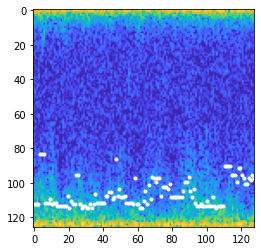

<Figure size 432x288 with 0 Axes>

In [ ]:
spectrogram(training, track_id=11, color_map_path='/content/cmap.npy');

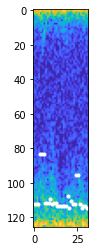

<Figure size 432x288 with 0 Axes>

In [ ]:
# Plot spectrogram of the first segme.
spectrogram(training, segment_id=0, color_map_path='/content/cmap.npy');

In [ ]:
# A track of a signal can have both High and Low SNR segments
# 'spectrogram' function supports plotting High SNR, Low SNR or both via snr_plot argument
# Checking if a track has one or more SNR types use 'has_single_snr_type' function
# The function supports both segment and track inputs
print(f'Segment 0 is part of a track of single SNR type: {has_single_snr_type(training, id=0, is_segment=True)}')
track_id = get_track_id(training, segment_id=0)
print(f'Segment 0 track id: {track_id}')
print(f'Track {track_id} has a single SNR type: {has_single_snr_type(training, id=track_id, is_segment=False)}')
print(f'Track 2 has a single SNR type: {has_single_snr_type(training, id=2, is_segment=False)}')

Segment 0 is part of a track of single SNR type: False
Segment 0 track id: 11
Track 11 has a single SNR type: False
Track 2 has a single SNR type: True


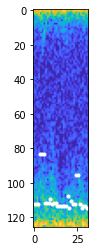

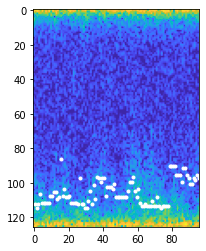

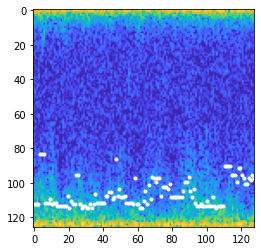

<Figure size 432x288 with 0 Axes>

In [ ]:
# Plot the entire track from the first segment (gathering all other segments that are in the same track)
# This specific track has both High and Low SNR types. 
# Below an example of plotting the entire track and separate by snr_type.
spectrogram(training, segment_id=0, plot_track=True, snr_plot='HighSNR',
            color_map_path='/content/cmap.npy')
spectrogram(training, segment_id=0, plot_track=True, snr_plot='LowSNR',
            color_map_path='/content/cmap.npy')
spectrogram(training, segment_id=0, plot_track=True, snr_plot='both',
            color_map_path='/content/cmap.npy');

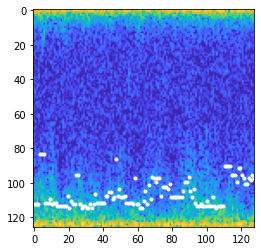

<Figure size 432x288 with 0 Axes>

In [ ]:
# Spectrogram can be plotted based on a track_id. 
# Note that snr_plot default is 'both'
spectrogram(training, track_id=track_id, plot_track=True, color_map_path='/content/cmap.npy');

#### plotting spegtogram for animal / human - all SNR option

In [ ]:
def plot_track_snrs_target(data, num_pictures, target):

    if target == 'animal':
      filt = set(data["track_id"][np.where(training['target_type'] == 'animal')])
    else:
      filt = set(data["track_id"][np.where(training['target_type'] == 'human')])

    both_snr_track = [track for track in filt if not has_single_snr_type(training, track, is_segment=False)]

    print(f"Plots of {target} - highSNR, lowSNR and both for the same segment")

    for row in range(num_pictures):
        
        ax = plt.gca()
        ax.set_title("HighSNR")
        spectrogram(data, track_id=both_snr_track[row],snr_plot='HighSNR', color_map_path='/content/cmap.npy')
      
        ax = plt.gca()
        ax.set_title("LowSNR")
        spectrogram(data, track_id=both_snr_track[row],snr_plot='LowSNR', color_map_path='/content/cmap.npy')
        
        ax = plt.gca()
        ax.set_title("both")
        spectrogram(data, track_id=both_snr_track[row],snr_plot='both', color_map_path='/content/cmap.npy')

        print("-------------------------------------------------------\n")
            

In [ ]:
plot_track_snrs_target(training, 20, "animal")

Output hidden; open in https://colab.research.google.com to view.

Plots of human - highSNR, lowSNR and both for the same segment


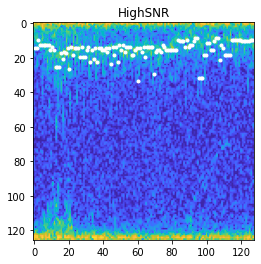

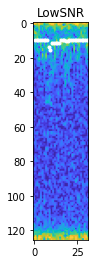

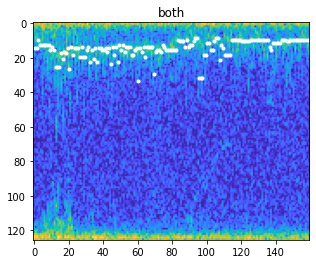

-------------------------------------------------------



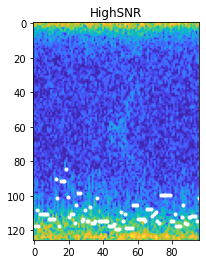

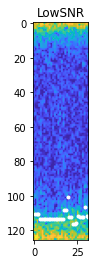

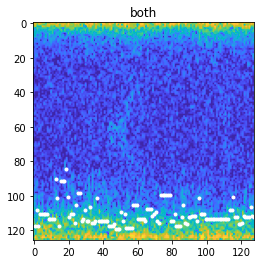

-------------------------------------------------------



<Figure size 432x288 with 0 Axes>

In [ ]:
plot_track_snrs_target(training, 2, "human")

#### take the spec and plot seprately

plot spectogram for python form

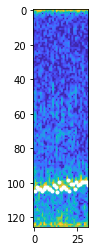

In [ ]:
doppler_burst, iq = spectrogram(training, segment_id=10, return_spec=True, color_map_path='/content/cmap.npy')

pixel_shift = 0.5
plt.plot(pixel_shift + np.arange(len(doppler_burst)), pixel_shift + (len(iq) - doppler_burst), '.w')

#plt.plot(pixel_shift + np.arange(len(doppler_burst)), pixel_shift + doppler_burst, '.w') # matlab case

cm_data = np.load('/content/cmap.npy')
color_map = LinearSegmentedColormap.from_list('parula', cm_data)
plt.imshow(iq, cmap=color_map);

plot spectogram for matlab form

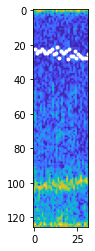

In [ ]:
doppler_burst, iq = spectrogram(training, segment_id=10, return_spec=True, color_map_path='/content/cmap.npy')

pixel_shift = 0.5

plt.plot(pixel_shift + np.arange(len(doppler_burst)), pixel_shift + doppler_burst, '.w') # matlab case

cm_data = np.load('/content/cmap.npy')
color_map = LinearSegmentedColormap.from_list('parula', cm_data)
plt.imshow(iq, cmap=color_map);

#### test dataset

In [ ]:
test_path = 'MAFAT RADAR Challenge - Public Test Set V1'
testing = load_data(test_path)

In [ ]:
testing.keys(), training.keys()

(dict_keys(['segment_id', 'snr_type', 'doppler_burst', 'iq_sweep_burst']),
 dict_keys(['segment_id', 'track_id', 'geolocation_type', 'geolocation_id', 'sensor_id', 'snr_type', 'date_index', 'target_type', 'doppler_burst', 'iq_sweep_burst']))

In [ ]:
testing['segment_id']

array([6656, 6658, 6662, 6664, 6665, 6666, 6668, 6676, 6681, 6682, 6683,
       6686, 6712, 6716, 6719, 6722, 6725, 6726, 6730, 6737, 6743, 6745,
       6750, 6752, 6754, 6756, 6757, 6758, 6760, 6762, 6767, 6790, 6791,
       6796, 6797, 6798, 6799, 6804, 6809, 6812, 6818, 6819, 6820, 6823,
       6826, 6831, 6834, 6835, 6836, 6837, 6838, 6839, 6841, 6843, 6846,
       6848, 6859, 6866, 6867, 6868, 6869, 6875, 6880, 6881, 6884, 6886,
       6888, 6890, 6891, 6893, 6895, 6899, 6903, 6904, 6905, 6909, 6918,
       6921, 6924, 6926, 6932, 6933, 6935, 6936, 6938, 6939, 6945, 6950,
       6951, 6954, 6956, 6964, 6968, 6971, 6972, 6973, 6976, 6977, 6978,
       6982, 6986, 6987, 6994, 6995, 6998, 7001], dtype=int32)

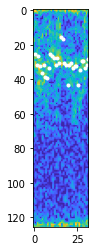

<Figure size 432x288 with 0 Axes>

In [ ]:
spectrogram(testing, segment_id=6804, color_map_path='/content/cmap.npy');

### function for presenting animal and human side by side

In [ ]:
def plot_animal_versus_human(data, num_examples=3, return_spec=True, color_map_path='/content/cmap.npy'):

    pixel_shift = 0.5
    cm_data = np.load(color_map_path)
    color_map = LinearSegmentedColormap.from_list('parula', cm_data)


    animals_list = list(set(data["track_id"][np.where(training['target_type'] == 'animal')]))
    humans_list = list(set(data["track_id"][np.where(training['target_type'] == 'human')]))

    animals = np.random.choice(animals_list, size=num_examples)
    humans = np.random.choice(humans_list, size=num_examples)

    fig, ax = plt.subplots(num_examples, 2, figsize=(15, 3*num_examples))

    for i in range(num_examples):
      doppler_burst_animal, iq_animal = spectrogram(data, track_id=animals[i], return_spec=return_spec, color_map_path=color_map_path)
      doppler_burst_human, iq_human = spectrogram(data, track_id=humans[i], return_spec=return_spec, color_map_path=color_map_path)

      ax[i][0].plot(pixel_shift + np.arange(len(doppler_burst_animal)), pixel_shift + (len(iq) - doppler_burst_animal), '.w')
      ax[i][1].plot(pixel_shift + np.arange(len(doppler_burst_human)), pixel_shift + (len(iq) - doppler_burst_human), '.w')

      ax[i][0].imshow(iq_animal, cmap=color_map);
      ax[i][1].imshow(iq_human, cmap=color_map);

      ax[i][0].set_title(f"animal - track id: {animals[i]}")
      ax[i][1].set_title(f"human - track id: {humans[i]}")
    
    plt.tight_layout()
  

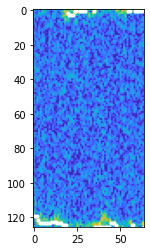

<Figure size 432x288 with 0 Axes>

In [ ]:
spectrogram(training, track_id=410, color_map_path='/content/cmap.npy');

In [ ]:
plot_animal_versus_human(training, num_examples=20)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
gen = ImageDataGenerator(horizontal_flip=True)

In [ ]:
#flip_photos = gen.flow_from_dataframe()